In [19]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import sys
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib

In [20]:
register_matplotlib_converters()

with pd.HDFStore('daily_combined_data.hdf') as store:
    daily_keys = [key[1:] for key in store.keys()]

In [21]:
def plot_errors(model, X_valid, y_valid, output_filename):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('models/errors_{}.png'.format(output_filename))
    plt.close()

def plot_model(df, model, output_filename, filter_month=None):
   # df['date'] = df.index.map(dt.datetime.toordinal)
    if filter_month:
        df = df[df['month'] == filter_month]
    # real values in blue, predicted values in red
    plt.plot(df['date'], df['water_level'], 'b.', alpha=0.5)
    plt.scatter(df['date'], model.predict(df[X_COLUMNS]), s=1, alpha=0.5, c='r')
    plt.show()
    plt.savefig('models/predict_{}.png'.format(output_filename))
    plt.close()
    

    
def model_scores(model, X_train, X_valid, y_train, y_valid):
    return {'train_score': model.score(X_train, y_train), 'valid_score': model.score(X_valid, y_valid)}

def train_and_generate_model(X_train, y_train, C, n_components, scaler):
    imputer = SimpleImputer()
    model = make_pipeline(
        imputer,
        scaler,
        PCA(n_components=n_components), # assume we have some kind of time, precip and temp dimensionality
        SVR(C=C, gamma='scale')
    )
    model.fit(X_train, y_train)
    return model

def prepare_df(df):
    df['date'] = df.index.map(dt.datetime.toordinal)
    y_column = 'water_level'
    X = df[X_COLUMNS]
    y = df['water_level'].values
    return (X, y)

In [22]:
def create_models(key,df=None, filter_month=None, show_plot=False, n_components=5, C=100, scaler=MinMaxScaler()):
    if df is None:
        df = pd.read_hdf('daily_combined_data.hdf', key=key).sort_index().dropna()
    X, y = prepare_df(df)
    
    if len(df) == 0:
        return None, None
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)

    model = train_and_generate_model(X_train, y_train, C=C, n_components=n_components, scaler=scaler)
    
    if show_plot:
        plot_model(df, model, key, filter_month)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
        
    return model, model_scores(model, X_train, X_valid, y_train, y_valid)

In [23]:
def PCA_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    for i in range(2,8):
        print(key, i, create_models(key, df=df, n_components=i)[1])
    print()

In [24]:
def SVR_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    for i in range(-3,3):
        print(key, i, create_models(key, df=df, C=10**i)[1])
    print()

In [25]:
def Scaler_test(key, daily=True):
    filename = 'daily_combined_data.hdf' if daily else 'monthly_combined_data.hdf'

    df = pd.read_hdf(filename, key=key).sort_index().dropna()
    print(key, 'standard', create_models(key, df=df, scaler=StandardScaler())[1])
    print(key, 'minmax', create_models(key, df=df, scaler=MinMaxScaler())[1])
    print(key, 'robust', create_models(key, df=df, scaler=RobustScaler())[1])
    print()

In [26]:
SAVE_MODELS = False
X_COLUMNS = ['date','year', 'month', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']
daily_keys

['hydro_07ED002',
 'hydro_08EB003',
 'hydro_08EC001',
 'hydro_08GA030',
 'hydro_08GA077',
 'hydro_08GA079',
 'hydro_08GB013',
 'hydro_08HA009',
 'hydro_08HB082',
 'hydro_08HC006',
 'hydro_08HD025',
 'hydro_08JA023',
 'hydro_08LC041',
 'hydro_08MH141',
 'hydro_08MH148',
 'hydro_08MH149',
 'hydro_08MH167',
 'hydro_08NA002',
 'hydro_08NB017',
 'hydro_08ND017',
 'hydro_08NE102',
 'hydro_08NE103',
 'hydro_08NE104',
 'hydro_08NE126',
 'hydro_08NH064',
 'hydro_08NH127',
 'hydro_08NM202',
 'hydro_08NM212',
 'hydro_08NM213',
 'hydro_08NM234']

In [ ]:
# WILL TERMINATE <5 mins. Use this to build models. Specific keys can also be set, shown above ^
# daily models
SAVE_MODELS=True
my_model_scores = dict()
# There are thirty stations in the dataframe
# Some of these do not have enough good data to build a model off of
# change slice size to build models for more than the first 5 models
slice_size = 5
for key in daily_keys[:slice_size]:
    model, scores = create_models(key, show_plot=True)
    print(key, scores)
    my_model_scores[key] = scores
    if SAVE_MODELS and scores is not None:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))

In [ ]:
my_model_scores

In [ ]:
# WILL NOT TERMINATE QUICKLY
# test best components. 5 looks pretty good
for key in daily_keys:
    PCA_test(key)

In [27]:
# WILL NOT TERMINATE QUICKLY
# test best C value. 10e2 looks good, in terms of time/accuraccy tradeoff
for key in daily_keys:
    SVR_test(key)

hydro_07ED002 -3 {'train_score': 0.057557866540299596, 'valid_score': 0.0662258446424131}
hydro_07ED002 -2 {'train_score': 0.4423870517211518, 'valid_score': 0.45187552825520083}
hydro_07ED002 -1 {'train_score': 0.7436637479263535, 'valid_score': 0.7382021227999418}
hydro_07ED002 0 {'train_score': 0.8420409724629703, 'valid_score': 0.8345456048249997}
hydro_07ED002 1 {'train_score': 0.86636616153256, 'valid_score': 0.8578047032302814}
hydro_07ED002 2 {'train_score': 0.8925475526613906, 'valid_score': 0.8774868130228608}

hydro_08EB003 -3 {'train_score': 0.051647021015442274, 'valid_score': 0.056891946050532494}
hydro_08EB003 -2 {'train_score': 0.37165132308746474, 'valid_score': 0.39254536733465484}
hydro_08EB003 -1 {'train_score': 0.5852875922812861, 'valid_score': 0.5874443917205399}
hydro_08EB003 0 {'train_score': 0.7050369547144667, 'valid_score': 0.689263163644142}
hydro_08EB003 1 {'train_score': 0.7634269299598626, 'valid_score': 0.7316079463678866}
hydro_08EB003 2 {'train_score'

hydro_08MH167 -1 {'train_score': 0.04299453783246232, 'valid_score': -0.0008537066520151181}
hydro_08MH167 0 {'train_score': 0.20057878213409064, 'valid_score': 0.19576803964162062}
hydro_08MH167 1 {'train_score': 0.44540443602996016, 'valid_score': 0.3576567303029935}
hydro_08MH167 2 {'train_score': 0.5109475843223366, 'valid_score': 0.48269307997533933}

hydro_08NA002 -3 {'train_score': 0.3429858034761124, 'valid_score': 0.3493890287843944}
hydro_08NA002 -2 {'train_score': 0.6777487104975146, 'valid_score': 0.6797521759935099}
hydro_08NA002 -1 {'train_score': 0.7699554566093108, 'valid_score': 0.768720283380909}
hydro_08NA002 0 {'train_score': 0.8194327599557949, 'valid_score': 0.7995040096698689}
hydro_08NA002 1 {'train_score': 0.8411414894516549, 'valid_score': 0.8309591625137085}
hydro_08NA002 2 {'train_score': 0.8533287617999903, 'valid_score': 0.8528288956530572}

hydro_08NB017 -3 {'train_score': 0.08404397862237867, 'valid_score': 0.09066151287744484}
hydro_08NB017 -2 {'train_s

In [ ]:
# WILL NOT TERMINATE QUICKLY
# test best scaler. minmax looks the best
for key in daily_keys:
    Scaler_test(key)

In [ ]:
# Use this to filter a date range out of a dataframe and check the prediction
key =  'hydro_08MH149'
df = pd.read_hdf('daily_combined_data.hdf', key=key).sort_index().dropna()

start ='1990-01-01'#format: %Y-%m-%d 
end = '2000-07-16' #format: %Y-%m-%d
def filter_by_date_range(df,start,end):
    df = df.reset_index(drop=False)
    df = df.rename(columns={'index':'Date/Time'})
    df['Date/Time'] = pd.to_datetime(df['Date/Time'],format="%Y-%m-%d",errors='coerce')
    df = df[pd.notnull(df['Date/Time'])]

    df = df[(df['Date/Time'] <= end) &(df['Date/Time'] >= start)]
    
    return df.set_index('Date/Time')

model = joblib.load('./models/model-hydro_{hydro_id}.pckl'.format(hydro_id=key[6:]))#create_models(key)[0]

model.predict(prepare_df(filter_by_date_range(df, start, end))[0])

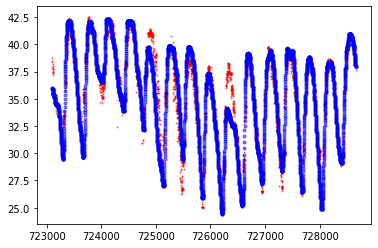

FileNotFoundError: [Errno 2] No such file or directory: 'models/predict_hydro_07ED002.png'

<Figure size 432x288 with 0 Axes>

In [29]:
# plot a specific month for a model
create_models('hydro_07ED002', show_plot=True)[1]